# Time Series forecasting with XGBoost

## Table of content
1. [Data](#data)
2. [Train/Test Split](#train-test)
3. [Create Time Series Features](#Features)
4. [Create XGBoost Model](#xgbmodel)
- [Feature Importances](#featimpor)
5. [Forecast on Test Set](#forecast)
6. [Look at first month of predictions](#firstmonth)
7. [Error Metrics On Test Set](#error)

### Data <a id="data"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Pulling the PJM East which has data from 2002-2018 for the entire east region.
pjme = pd.read_csv('PJME_hourly.csv', index_col=[0], parse_dates=[0])

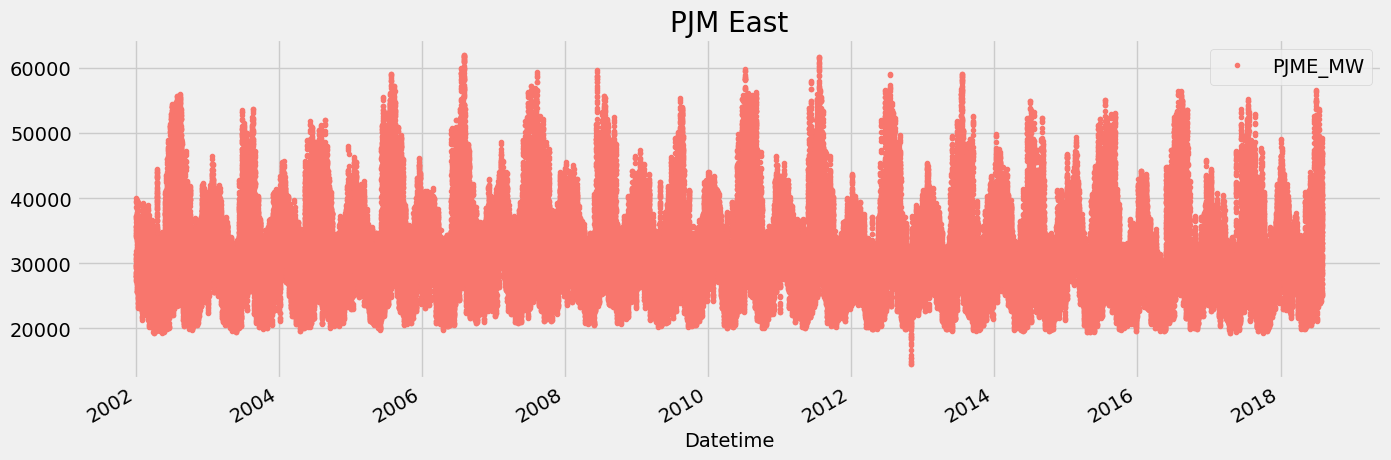

In [4]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

### Train/Test Split<a id="train-test"></a>

In [5]:
#Cut off the data after 2015 to use as our validation set.
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [6]:
pjme_train.dtypes

PJME_MW    float64
dtype: object

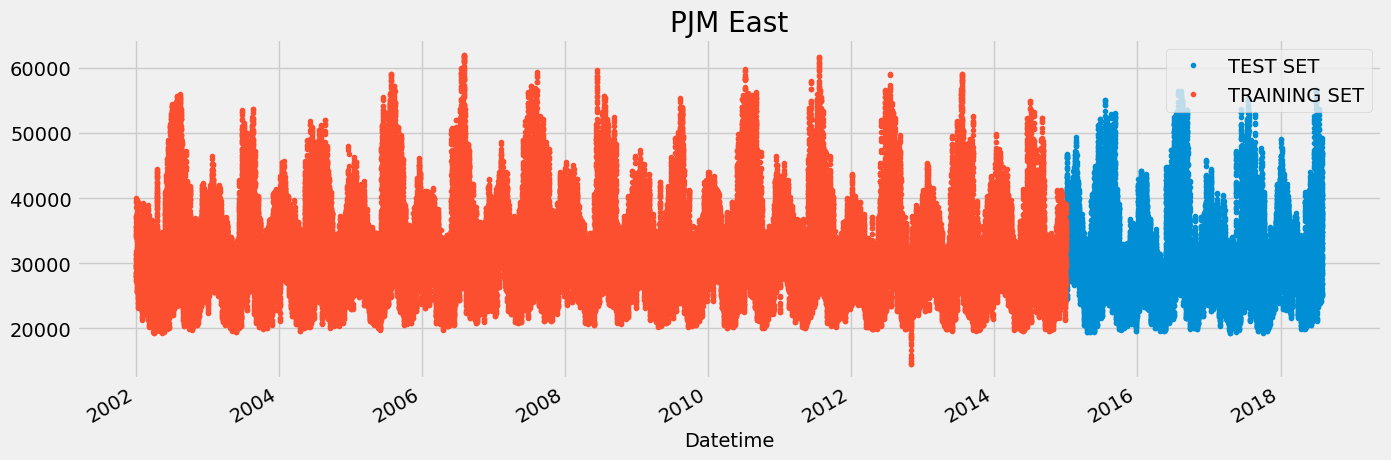

In [7]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

#### Rolling and Lag Features<a id="roll"></a>

##### Demostration of Lag Features<a id="demostration"></a>

In [8]:
pjme_train.head(7)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
2002-12-31 06:00:00,26222.0
2002-12-31 07:00:00,28702.0


In [9]:
pjme_train.head(7).shift(1)
 #Độ trễ coi là sử dụng thông tin trong quá khứ để dự đoán tương lai, sử dụng độ trễ là 1

,PJME_MW
Datetime,
2002-12-31 01:00:00,NaN
2002-12-31 02:00:00,26498.0
2002-12-31 03:00:00,25147.0
2002-12-31 04:00:00,24574.0
2002-12-31 05:00:00,24393.0
2002-12-31 06:00:00,24860.0
2002-12-31 07:00:00,26222.0


In [10]:
pjme_train.head(7).rolling(window = 2).mean()

,PJME_MW
Datetime,
2002-12-31 01:00:00,NaN
2002-12-31 02:00:00,25822.5
2002-12-31 03:00:00,24860.5
2002-12-31 04:00:00,24483.5
2002-12-31 05:00:00,24626.5
2002-12-31 06:00:00,25541.0
2002-12-31 07:00:00,27462.0


### Create Time Series Features<a id="Features"></a>

<p>Sử dụng kích thước cửa sổ là 6,12,24 vì dữ liệu được lấy mẫu hàng giờ, điều này tương ứng với độ trễ là 6,12,24 giờ</p>

In [11]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    
    df['weekofyear'] = df['date'].dt.isocalendar().week

    df['weekofyear'] = df['weekofyear'].astype('int64')
    df['pjme_6_hrs_lag'] = df['PJME_MW'].shift(6)
    df['pjme_12_hrs_lag'] = df['PJME_MW'].shift(12)
    df['pjme_24_hrs_lag'] = df['PJME_MW'].shift(24)
    df['pjme_6_hrs_mean'] = df['PJME_MW'].rolling(window = 6).mean()
    df['pjme_12_hrs_mean'] = df['PJME_MW'].rolling(window = 12).mean()
    df['pjme_24_hrs_mean'] = df['PJME_MW'].rolling(window = 24).mean()
    df['pjme_6_hrs_std'] = df['PJME_MW'].rolling(window = 6).std()
    df['pjme_12_hrs_std'] = df['PJME_MW'].rolling(window = 12).std()
    df['pjme_24_hrs_std'] = df['PJME_MW'].rolling(window = 24).std()
    df['pjme_6_hrs_max'] = df['PJME_MW'].rolling(window = 6).max()
    df['pjme_12_hrs_max'] = df['PJME_MW'].rolling(window = 12).max()
    df['pjme_24_hrs_max'] = df['PJME_MW'].rolling(window = 24).max()
    df['pjme_6_hrs_min'] = df['PJME_MW'].rolling(window = 6).min()
    df['pjme_12_hrs_min'] = df['PJME_MW'].rolling(window = 12).min()
    df['pjme_24_hrs_min'] = df['PJME_MW'].rolling(window = 24).min()
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear' , 'pjme_6_hrs_lag' , 'pjme_24_hrs_lag' , 'pjme_6_hrs_mean',
           "pjme_12_hrs_mean" ,"pjme_24_hrs_mean" ,"pjme_6_hrs_std" ,"pjme_12_hrs_std" ,"pjme_24_hrs_std",
           "pjme_6_hrs_max","pjme_12_hrs_max" ,"pjme_24_hrs_max" ,"pjme_6_hrs_min","pjme_12_hrs_min" ,"pjme_24_hrs_min"]]
    if label:
        y = df[label]
        return X, y
    return X

<p> Tạo ra tập huấn luyện (X_train, y_train) và tập kiểm tra (X_test, y_test) từ dữ liệu trong hai DataFrame pjme_train và pjme_test.</p>

In [12]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

### Create XGBoost Model <a id="xgbmodel"></a>

<p>Mô hình hồi quy XGBoost được tạo và huấn luyện bằng cách sử dụng dữ liệu huấn luyện (X_train và y_train)</p>

In [13]:
model = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)

# Fit mô hình với dữ liệu và eval_set
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### Feature importance<a id="featimpor"></a>

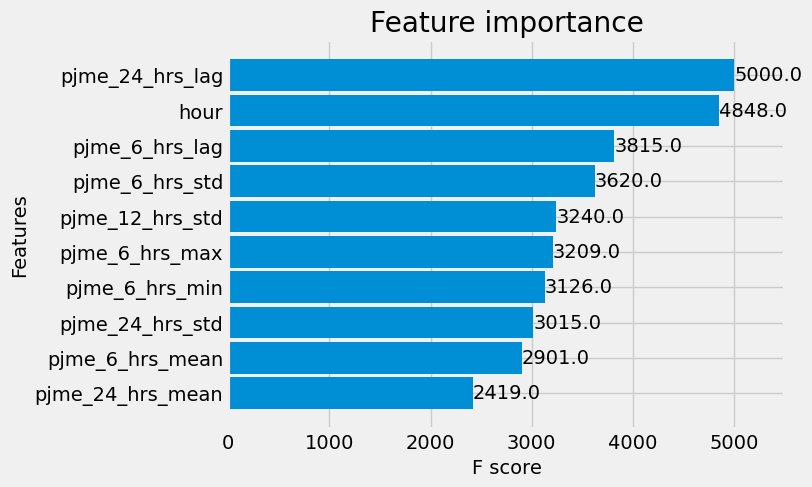

In [14]:
_ = plot_importance(model, height=0.9 ,max_num_features = 10)

### Forecast on Test Set<a id="forecast"></a>

In [15]:
pjme_test['MW_Prediction'] = model.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

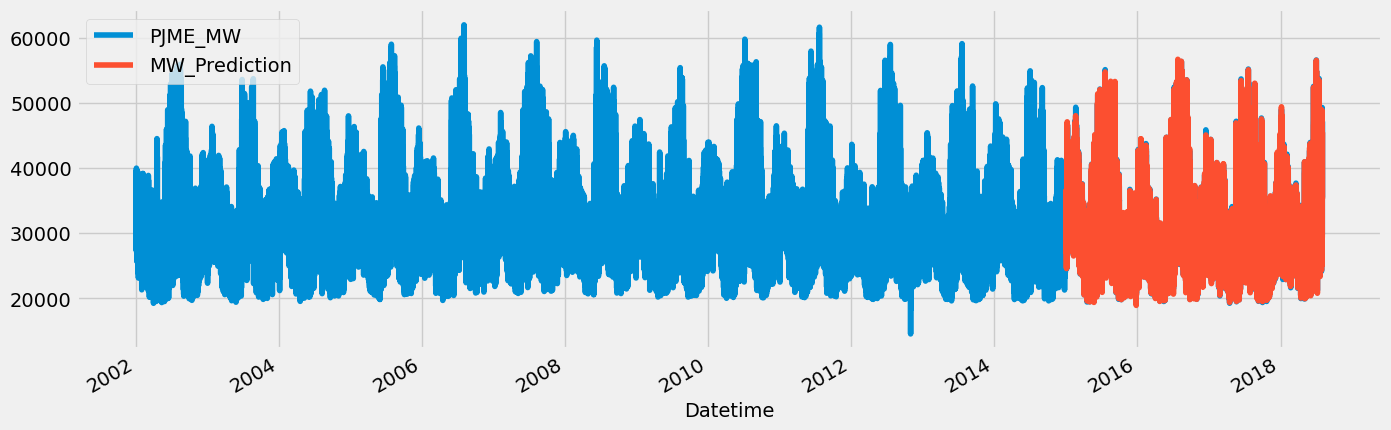

In [16]:
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

### Look at first month of predictions<a id="firstmonth"></a>

<p>Dự báo tuần đầu tiên của tháng 1 so với thực tế</p>

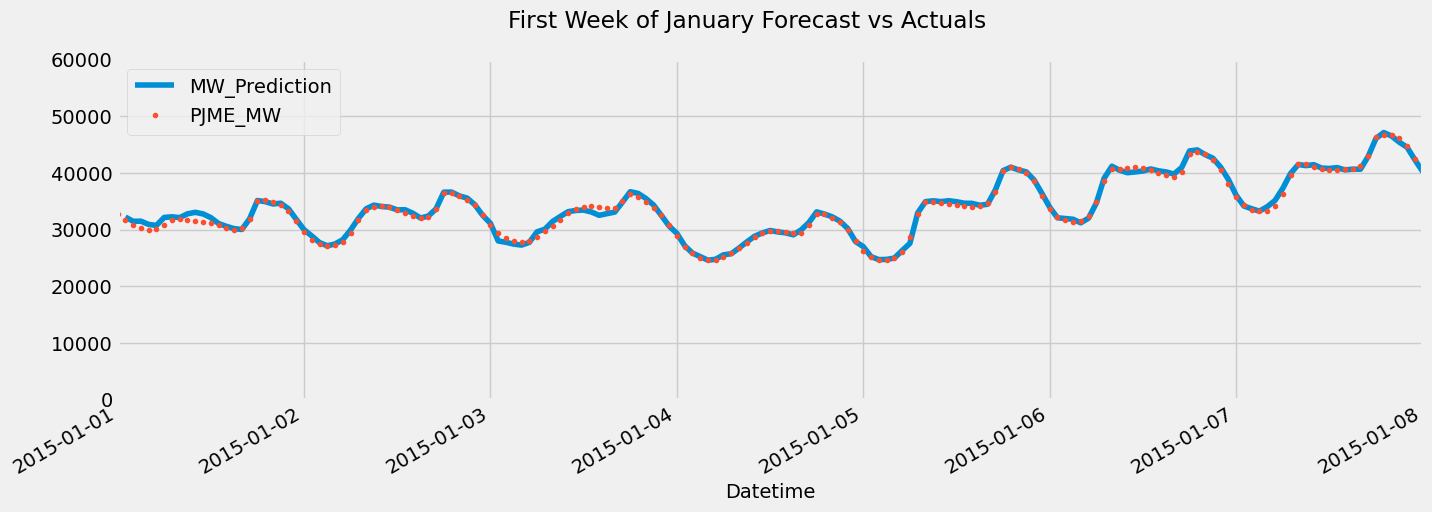

In [17]:
pjme_all['date'] = pd.to_datetime(pjme_all['date'])

# Vẽ biểu đồ
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction', 'PJME_MW']].plot(ax=ax, style=['-', '.'])
ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-01-08'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

# Hiển thị biểu đồ
plt.show()

<p>Dự báo tuần đầu tiên của tháng 7 so với thực tế</p>

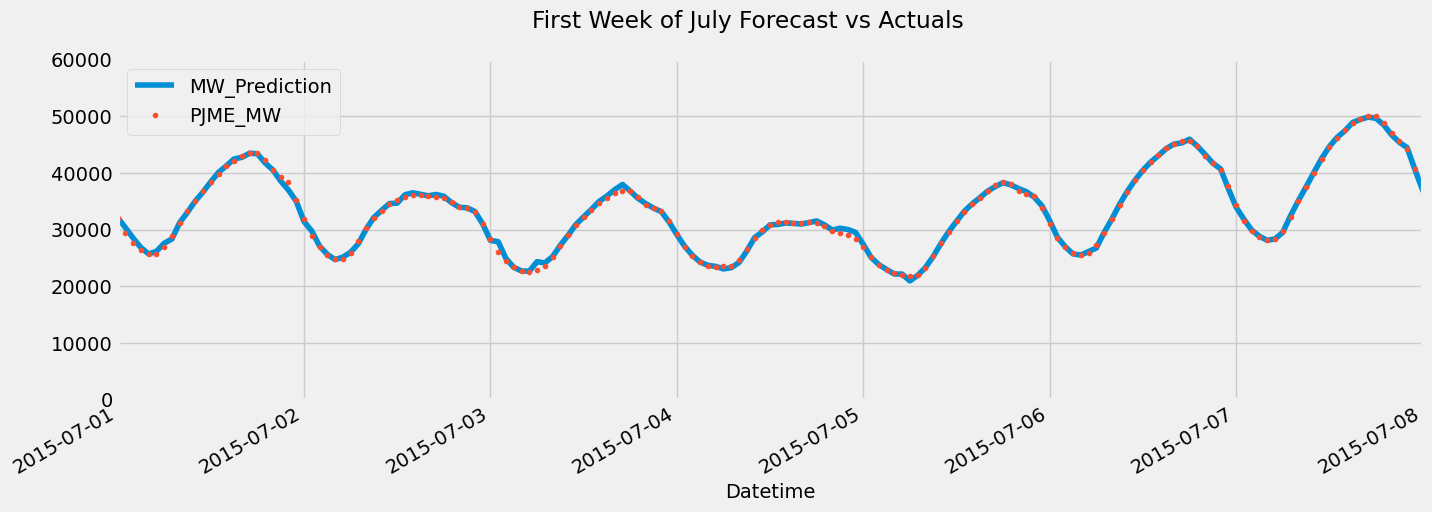

In [18]:
pjme_all['date'] = pd.to_datetime(pjme_all['date'])

# Vẽ biểu đồ
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction', 'PJME_MW']].plot(ax=ax, style=['-', '.'])
ax.set_xlim(pd.Timestamp('2015-07-01'), pd.Timestamp('2015-07-08'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of July Forecast vs Actuals')

# Hiển thị biểu đồ
plt.show()

### Error Metrics On Test Set<a id="error"></a>

<p>1. Our RMSE error is 322870.893729171<br>
2. Our MAE error is 331<br>
3. Our MAPE error is 1.06%</p>

In [19]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

322870.893729171

In [20]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

331.24599932110596

In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

1.0642971647684323